In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"
match_dist <- 15000
new_dataset <- "FVG"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    anti_join(tibble(sensor_key = c(3984L, 2938L, 2939L), dataset = c("SCIA", "ISAC", "ISAC")), copy = TRUE, by = c("dataset", "sensor_key")) |> # TRIESTE provides terrible data + AT stations
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 10000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Veneto"), !str_starts(series_id, "AT_"))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.xlsx"))
# analysis <- read_parquet(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.parquet"))


In [5]:
source("notebooks/ds_regionali/FVG/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
# Dealing with ISAC series
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    c("ARPAFVG", "SCIA", "ISAC"),
    desc(dataset), desc(sensor_last)
)
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 15L, 0.5, ignore_corrections)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
136,-0.3832008,-2.38097858,0.004433341,-0.10031701,68,411,305,1,1,RACCOLANA,Idrografica,3168,CHIUSAFORTE,Idrografica,793
43,1.8981001,0.00000000,0.000000000,0.00000000,29,34,163,-1,1,Muggia,ARPAFVG,36,MUGGIA,DPC,2290
37,-1.8493895,0.00000000,0.000000000,0.00000000,25,29,158,-1,0,Monfalcone (fino al 23/04/2021),ARPAFVG,31,MONFALCONE,DPC,2096
57,1.7269805,0.00000000,0.000000000,0.00000000,29,34,371,-1,-1,Muggia,ARPAFVG,36,MUGGIA,Idrografica,2221
352,-1.6997626,0.16072170,0.260470996,0.51792032,176,462,460,1,1,UDINE/RIVOLTO,Sinottica,4095,UDINE RIVOLTO,Sinottica,4093
15,-0.7780447,-1.05494314,-0.018806368,0.02253024,8,11,301,-1,-1,Cave del Predil,ARPAFVG,11,CAVE DEL PREDIL,Idrografica,752
59,-1.4247883,0.05965458,0.026937128,0.08855241,43,48,441,-1,-1,Tarvisio,ARPAFVG,51,TARVISIO,Idrografica,3912
67,-1.5031560,0.27361087,-0.216210090,-0.13613210,34,39,393,-1,-1,Piancavallo,ARPAFVG,41,PIANCAVALLO PISTA DI FONDO,Idrografica,2784
49,-1.7484335,0.69110714,-0.079592083,-0.10124655,34,39,180,-1,0,Piancavallo,ARPAFVG,41,PIANCAVALLO,DPC,2597


In [8]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, gs$table)
rm(merge_results)
gc()

# Attenzione! Associare i metadati OSMER (vedi sotto)


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2181069,116.5,4807318,256.8,NA,4807318,256.8
Vcells,25625527,195.6,111908529,853.8,16384,139885649,1067.3


In [ ]:
# Non eseguire! Procedura per la riassegnazione dei metadati da OSMER
source("notebooks/ds_regionali/FVG/procedures/load_daily.R")
om <- query_checkpoint_meta("FVG", "merged", conns$data) |> collect()
nm <- load_osmer_meta()

assocs1 <- closest_within(om |> select(sensor_key, lon, lat), nm |> select(user_code, lon, lat), 170, conns$stations) |>
    group_by(sensor_key) |>
    slice_min(distance) |>
    arrange(desc(distance)) |>
    left_join(om |> select(sensor_key, name)) |>
    left_join(nm |> select(user_code, name), by = "user_code")

om1 <- om |> anti_join(assocs1, by = "sensor_key")
nm1 <- nm |> anti_join(assocs1, by = "user_code")

assocs1 |>
    group_by(sensor_key) |>
    filter(n() > 1L) |>
    nrow()
assocs1 |>
    group_by(user_code) |>
    filter(n() > 1L) |>
    nrow()

assocs2_ <- closest_within(om1 |> select(sensor_key, lon, lat), nm1 |> select(user_code, lon, lat), 800, conns$stations) |>
    group_by(sensor_key) |>
    slice_min(distance) |>
    arrange(desc(distance)) |>
    left_join(om1 |> select(sensor_key, name)) |>
    left_join(nm1 |> select(user_code, name), by = "user_code")

assocs2 <- bind_rows(assocs1, assocs2_)
assocs2 |>
    group_by(sensor_key) |>
    filter(n() > 1L) |>
    nrow()
assocs2 |>
    group_by(user_code) |>
    filter(n() > 1L) |>
    nrow()

om2 <- om1 |> anti_join(assocs2, by = "sensor_key")
nm2 <- nm1 |> anti_join(assocs2, by = "user_code")

remaining <- closest_within(om2 |> select(sensor_key, lon, lat), nm2 |> select(user_code, lon, lat), 10000, conns$stations) |>
    left_join(om2 |> select(sensor_key, name, elevation), by = "sensor_key") |>
    left_join(nm2 |> select(user_code, name, elevation), by = "user_code")
remaining |> write.xlsx(file.path("notebooks", "ds_regionali", "FVG", "remaining.xlsx"), asTable = TRUE)
assocs2 |> write.xlsx(file.path("notebooks", "ds_regionali", "FVG", "assocs2.xlsx"), asTable = TRUE)
# remaining and assocs2 are manually merged in the Excel file


In [12]:
# Lanciare in caso di regenerazione del dataset merged
source("notebooks/ds_regionali/FVG/procedures/load_daily.R")
old_meta <- query_checkpoint_meta(new_dataset, "merged", conns$data) |>
    collect()
new_meta <- load_osmer_meta() |> select(-series_first, -gestore)
transition <- read.csv2(file.path("notebooks", "ds_regionali", "FVG", "pairing_codes.csv"), stringsAsFactors = FALSE)
updated_metas <- old_meta |>
    select(!all_of(colnames(new_meta))) |>
    inner_join(transition, by = "sensor_key") |>
    left_join(new_meta, by = "user_code")
remaining_metas <- old_meta |> anti_join(updated_metas, by = "sensor_key")
metas <- bind_rows(updated_metas, remaining_metas)
write_parquet(metas, file.path("db", "metadata", "merged", "FVG", "part-0.parquet"))


In [13]:
query_checkpoint_meta("FVG", "merged", conns$data) |>
    collect() |>
    write.xlsx("res.xlsx", asTable = T)


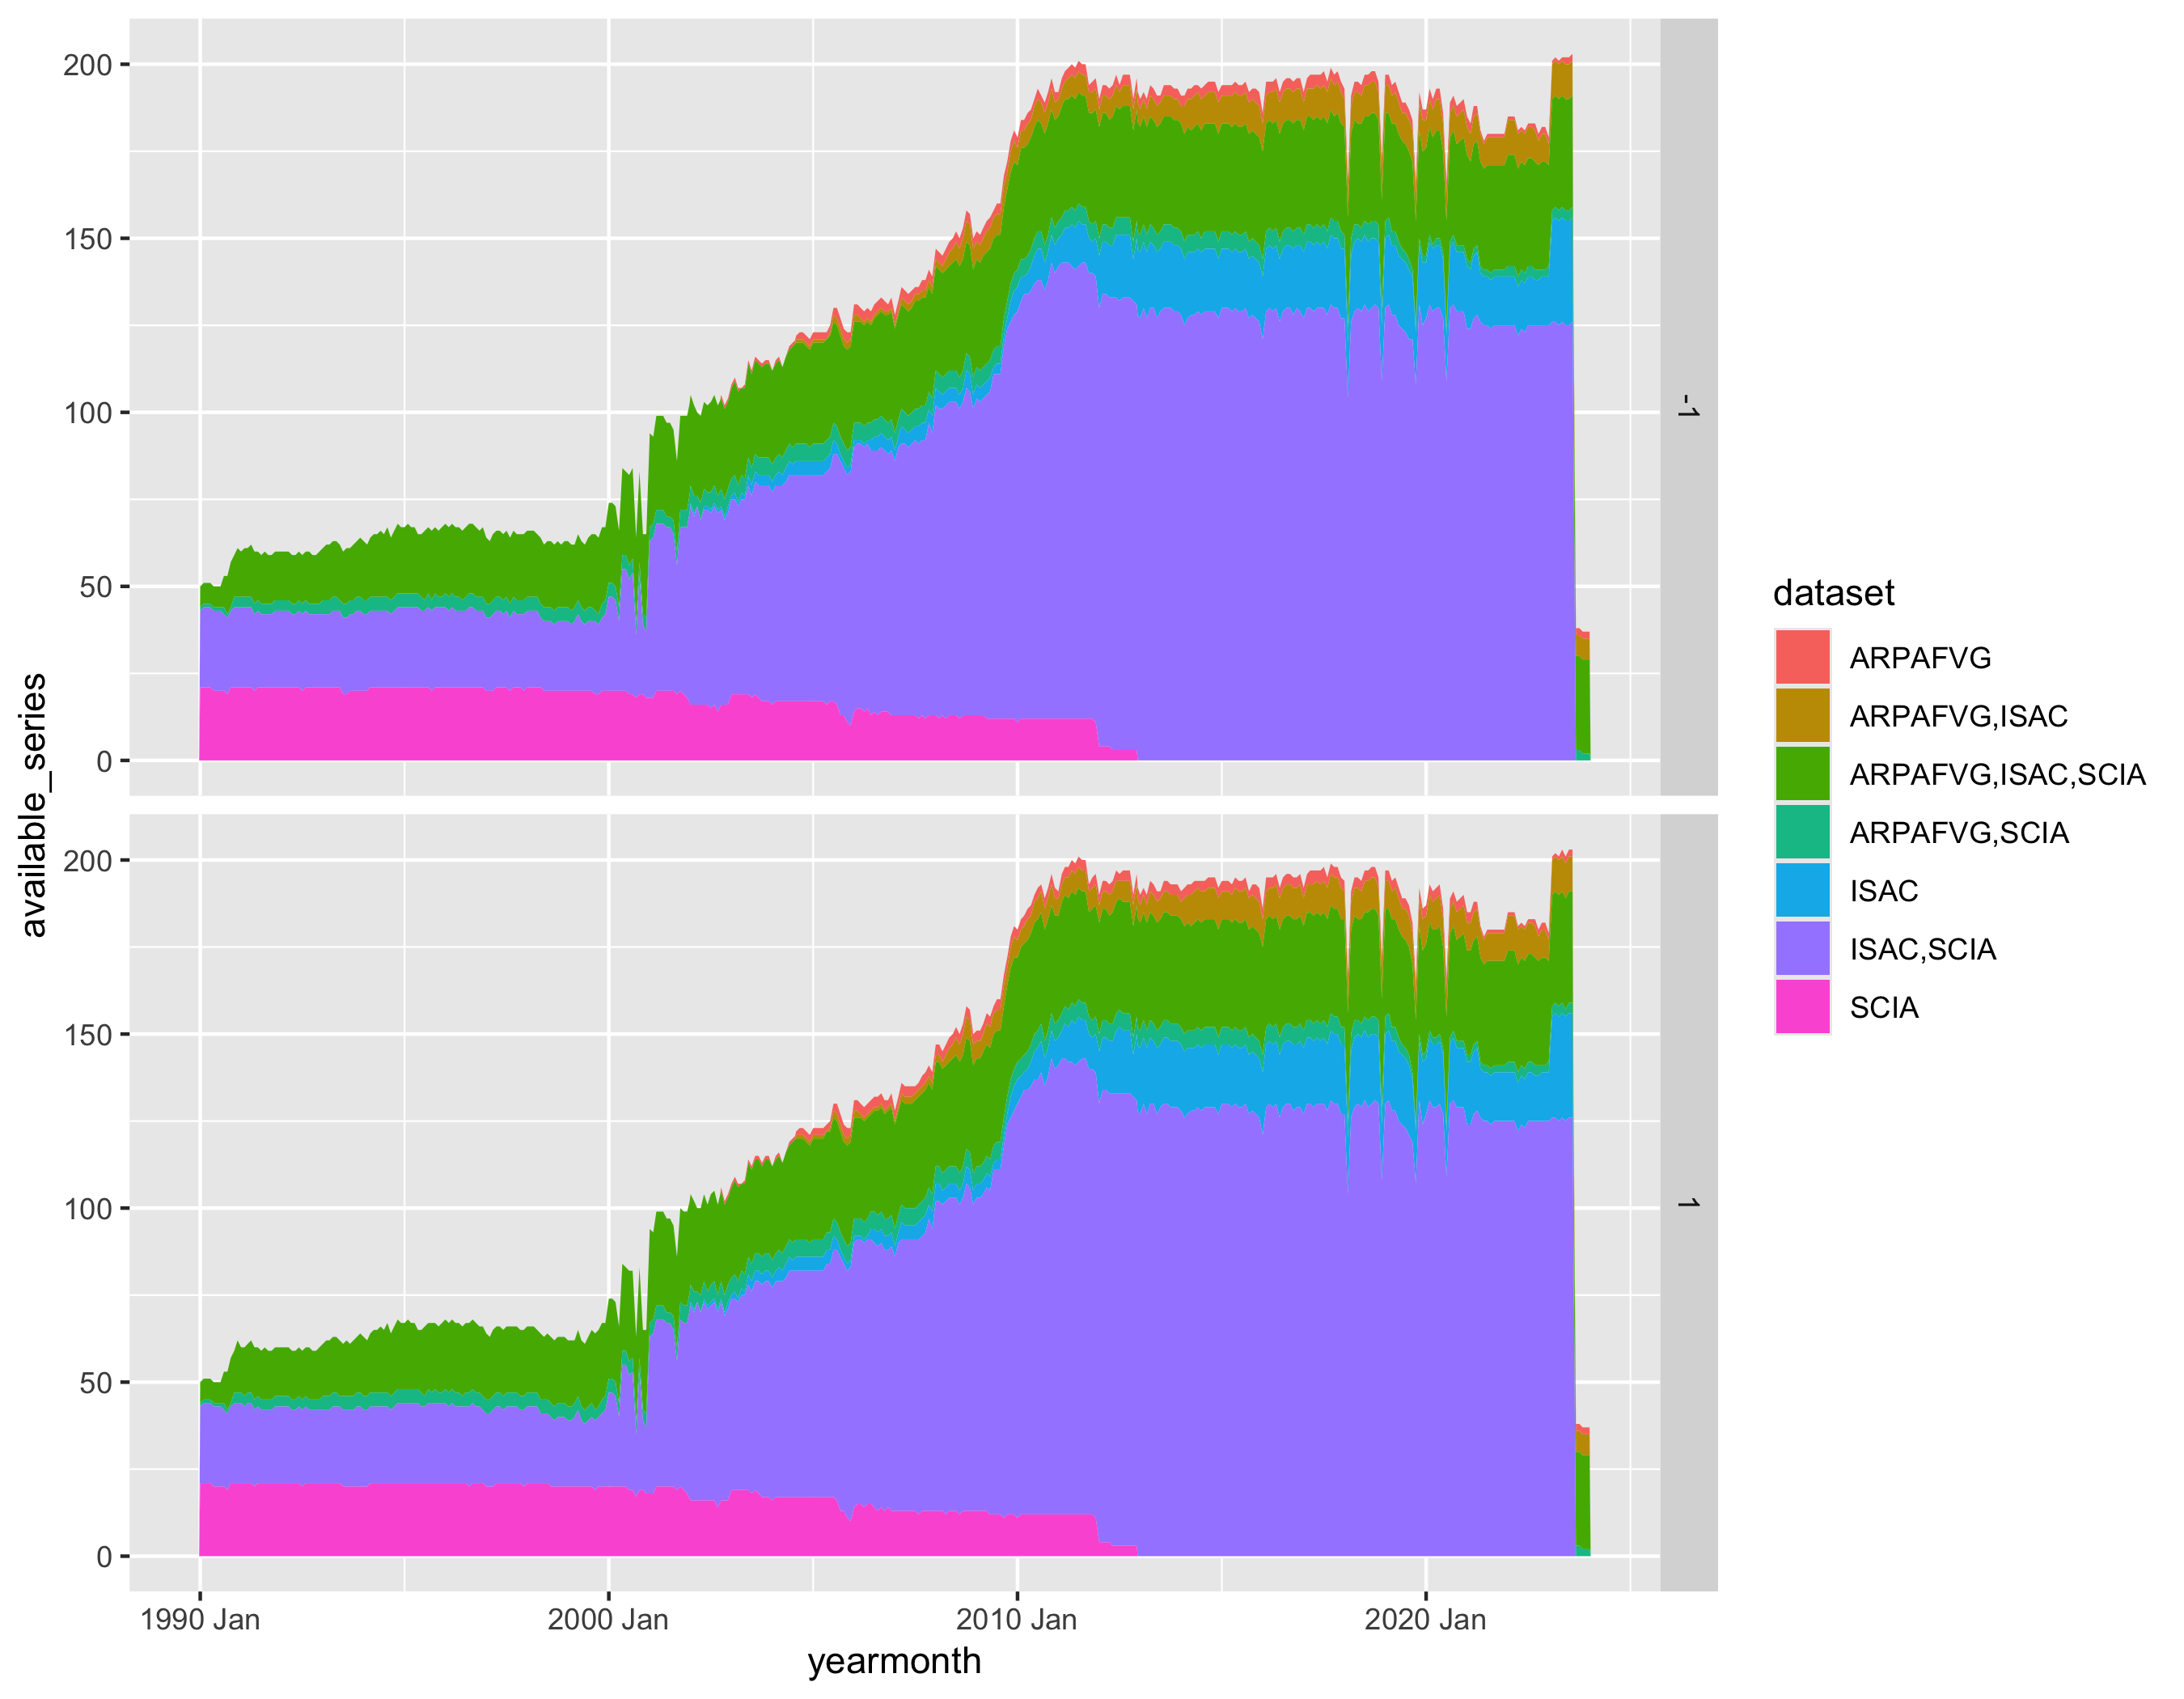

In [164]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


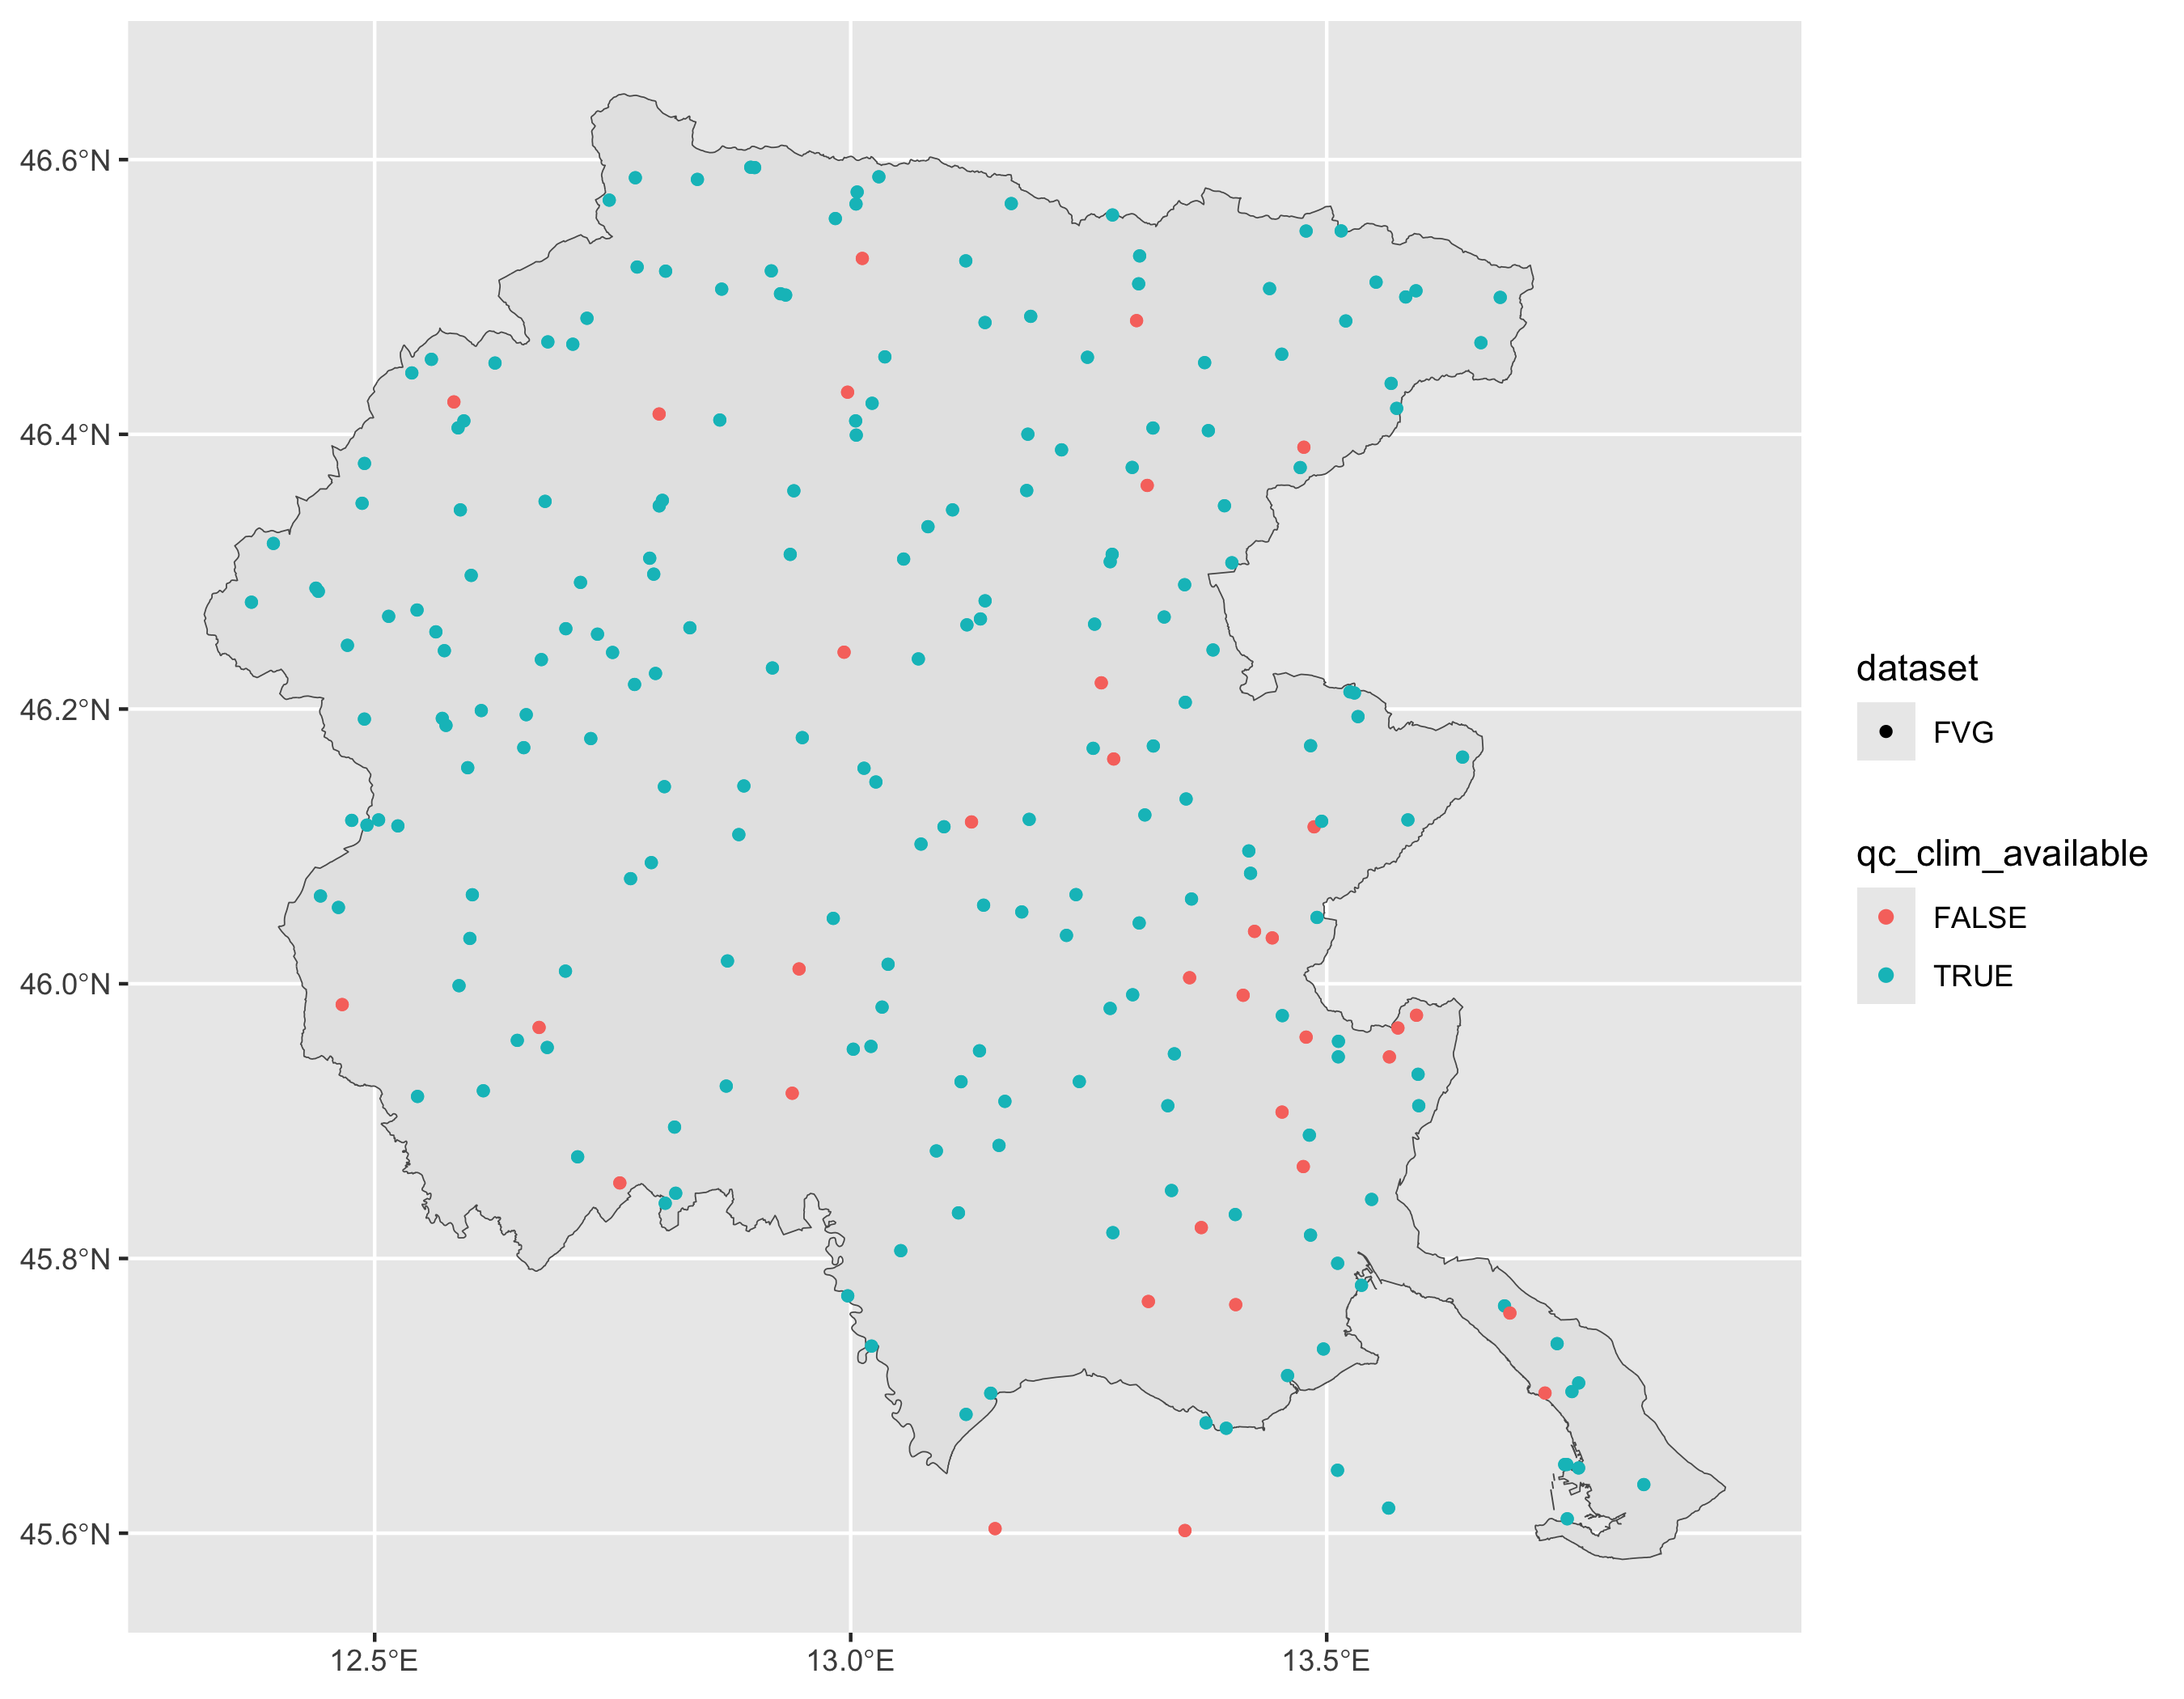

In [165]:
sp_data <- pd[[2]] |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries)
pd$plot


In [14]:
nm |>
    st_md_to_sf() |>
    st_write("kml_metadata/Friuli-Venezia Giulia/original/osmer.kml")


Writing layer `osmer' to data source 
  `kml_metadata/Friuli-Venezia Giulia/original/osmer.kml' using driver `KML'
Writing 237 features with 8 fields and geometry type Point.


In [9]:
source("notebooks/ds_regionali/FVG/procedures/load_daily.R")
om <- query_checkpoint_meta("FVG", "merged", conns$data) |> collect()
nm <- load_osmer_meta()


In [10]:
by_code <- om |>
    select(user_code, sensor_key) |>
    inner_join(nm, by = c("user_code"), relationship = "one-to-one")


In [11]:
st_join(
    om |> anti_join(by_code, by = "sensor_key") |> st_md_to_sf(),
    nm |> st_md_to_sf(),
    st_is_within_distance,
    dist = 5000,
    left = FALSE
) |>
    st_drop_geometry() |>
    mutate(strSym = stringdist::stringsim(str_to_lower(name.x), str_to_lower(name.y), "jw")) |>
    select(name.x, name.y, strSym, user_code.x, user_code.y) |>
    arrange(name.x, desc(strSym))


name.x,name.y,strSym,user_code.x,user_code.y
<chr>,<chr>,<dbl>,<chr>,<chr>
ALBANA,Spessa di Cividale,0.4074074,06N601,105
ALBANA,Prepotto,0.0000000,06N601,217500
ALESSO,Alesso,1.0000000,06C551,401500
AMPEZZO,Enemonzo,0.5238095,06C120,ENE
ANDRAZZA,Forni di Sopra,0.4702381,06C006,231300
ANDRAZZA,Forni di Sopra,0.4702381,06C006,FSP
ANDREIS PIAZZOLA CAMPEGGIO,Andreis,0.7564103,06A464,103600
ANDREIS PIAZZOLA CAMPEGGIO,Barcis,0.6068376,06A464,103400
ANDREIS PIAZZOLA CAMPEGGIO,Pala Barzana,0.6059829,06A464,503500
